In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from dataset import get_dataset
import torchvision
import numpy as np
from arch import DQN_Conv

# Tải mô hình đơn giản (ví dụ: ResNet)
from arch import MNIST_CC

# 1. Cấu hình thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Tải mô hình đã huấn luyện trước
model = MNIST_CC()
model.load_state_dict(torch.load('trained_model\mnist_cc.pth'))

model.eval().to(device)  # Đặt chế độ đánh giá (evaluation mode)

# 3. Định nghĩa FGSM Attack
def fgsm_attack(image, epsilon, gradient):
    # Lấy dấu của gradient
    sign_gradient = gradient.sign()
    # Tạo mẫu tấn công
    perturbed_image = image + epsilon * sign_gradient
    # Giới hạn giá trị pixel [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# 4. Chuẩn bị dữ liệu
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = get_dataset('mnist', split='train')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 5. Tấn công mẫu đầu tiên
epsilon = 0.1  # Mức độ nhiễu
criterion = nn.CrossEntropyLoss()


dqn = DQN_Conv(28*28, 14*14)
dqn.load_state_dict(torch.load('model_0_trenvong_2.pth'))
dqn.eval().to(device)


<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
C:\Users\hokha\AppData\Local\Temp\ipykernel_19900\3302583623.py:20: SyntaxWarning: invalid escape sequence '\m'
  model.load_state_dict(torch.load('trained_model\mnist_cc.pth'))
C:\Users\hokha\AppData\Local\Temp\ipykernel_19900\3302583623.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_sa

DQN_Conv(
  (classifier): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=9216, out_features=1024, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=128, out_features=196, bias=True)
  )
)

(14, 14)
Label gốc: 2, Dự đoán sau tấn công: 8


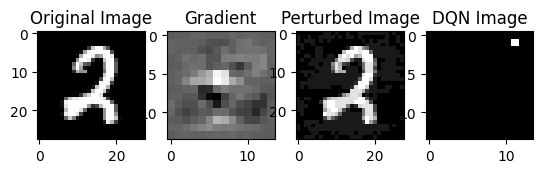

(14, 14)
Label gốc: 1, Dự đoán sau tấn công: 1


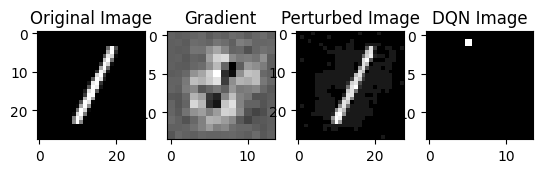

(14, 14)
Label gốc: 0, Dự đoán sau tấn công: 0


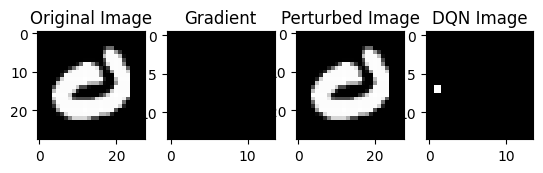

(14, 14)
Label gốc: 0, Dự đoán sau tấn công: 0


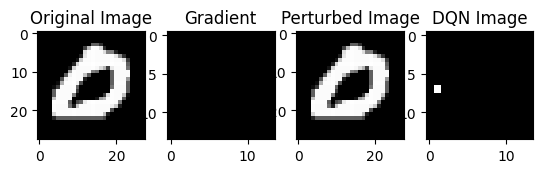

(14, 14)
Label gốc: 0, Dự đoán sau tấn công: 0


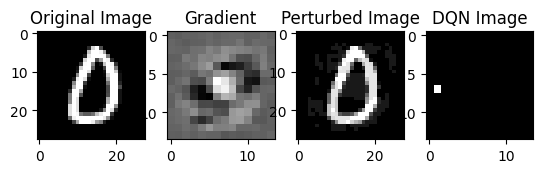

In [5]:

t = 5

for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)

    img_2_channel = torch.concatenate((images, images), 1)
    dqn_predict = dqn(img_2_channel)
    predict = dqn_predict.argmax(1)

    # dqn_img = dqn_predict.view(14, 14).detach().cpu().numpy()
    dqn_img = np.zeros((14, 14))
    dqn_img[predict//14, predict%14] = 1
    
    # Đặt chế độ tính gradient
    images.requires_grad = True
    
    # Dự đoán ban đầu
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Tính gradient
    model.zero_grad()
    loss.backward()
    gradient = images.grad.data

    grid_img = np.zeros((14, 14))
    for i in range(14):
        for j in range(14):
            grid_img[i, j] = gradient[0, 0, i*2:(i+1)*2, j*2:(j+1)*2].mean().item()

    print(grid_img.shape)
    
    # Tạo mẫu nhiễu
    perturbed_image = fgsm_attack(images, epsilon, gradient)
    
    # Kiểm tra dự đoán trên mẫu bị tấn công
    outputs_perturbed = model(perturbed_image)
    _, final_pred = outputs_perturbed.max(1)
    
    print(f"Label gốc: {labels.item()}, Dự đoán sau tấn công: {final_pred.item()}")

    # Hiển thị mẫu gốc, grad và mẫu bị tấn công
    import matplotlib.pyplot as plt
    plt.figure()
    plt.subplot(141)
    plt.imshow(images.squeeze().cpu().detach().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.subplot(142)
    plt.imshow(grid_img, cmap='gray')
    plt.title('Gradient')
    plt.subplot(143)
    plt.imshow(perturbed_image.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title('Perturbed Image')
    plt.subplot(144)
    plt.imshow(dqn_img, cmap='gray')
    plt.title('DQN Image')


    plt.show()
    
    t -= 1
    if t == 0:
        break
